<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Final project: NLP to predict Myers-Briggs Personality Type

## Imports

In [7]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import umap.plot
from yellowbrick.text import UMAPVisualizer

# Text Processing
import re
import itertools
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from collections import Counter

### Dimensionality reduction and embedding
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import umap

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.cluster as cluster
from sklearn.preprocessing import LabelEncoder

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

# Export data
import pickle as pkl
from scipy import sparse
from numpy import asarray
from numpy import savetxt

pd.set_option("display.max_column", None)

## 2. Data preprocessing

In [0]:
mbti_df = pd.read_csv("../data/mbti_1.csv")

### Cleaning text

In [0]:
type = ["type"]
posts = ["posts"]
columns = [*type, *posts]

In [0]:
mbti_df_raw = mbti_df
mbti_df_raw[type] = mbti_df[type].fillna("")
mbti_df_raw[posts] = mbti_df[posts].fillna("")
mbti_df_raw.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


#### Declare preprocessing functions

##### Cleaning functions

In [0]:
def clean_url(str_text_raw):
    """This function eliminate a string URL in a given text"""
    str_text = re.sub("url_\S+", "", str_text_raw)
    str_text = re.sub("email_\S+", "", str_text)
    str_text = re.sub("phone_\S+", "", str_text)
    return(re.sub("http[s]?://\S+", "", str_text))
    
def clean_punctuation(str_text_raw):
    """This function replace some of the troublemaker puntuation elements in a given text"""
    return(re.sub("[$\(\)/|{|\}#~\[\]^#;:!?¿]", " ", str_text_raw))

def clean_unicode(str_text_raw):
    """This function eliminate non-unicode text"""
    str_text = re.sub("&amp;", "", str_text_raw)
    return(re.sub(r"[^\x00-\x7F]+"," ", str_text))
                      
def clean_dot_words(str_text_raw):
    """This function replace dots between words"""
    return(re.sub(r"(\w+)\.+(\w+)", r"\1 \2",str_text_raw))

def clean_text(str_text_raw):
    """This function sets the text to lowercase and applies previous cleaning functions """
    str_text = str_text_raw.lower()
    str_text = clean_dot_words(clean_punctuation(clean_unicode(clean_url(str_text))))
    return(str_text)

##### Tokenization and lemmatization functions

In [0]:
tokens_to_drop=["+"]

def string_to_token(string, str_pickle = None):
    """
    This function takes a sentence and returns the list of tokens and all their information
    * Text: The original text of the lemma.
    * Lemma: Lemma.
    * Orth: The hash value of the lemma.
    * is alpha: Does the lemma consist of alphabetic characters?
    * is digit: Does the lemma consist of digits?
    * is_title: Is the token in titlecase? 
    * is_punct: Is the token punctuation?
    * is_space: Does the token consist of whitespace characters?
    * is_stop: Is the token part of a “stop list”?
    * is_digit: Does the token consist of digits?
    * lang: Language of the token
    * tag: Fine-grained part-of-speech. The complete list is in: 
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html, also using: spacy.explain("RB")
    * pos: Coarse-grained part-of-speech.
    * has_vector: A boolean value indicating whether a word vector is associated with the token.
    * vector_norm: The L2 norm of the token’s vector representation.
    * is_ovv: """
    doc = nlp(string)
    l_token = [[token.text, token.lemma_, token.orth, token.is_alpha, token.is_digit, token.is_title, token.lang_, 
        token.tag_, token.pos_, token.has_vector, token.vector_norm, token.is_oov]
        for token in doc if not token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_url 
               | token.like_num | token.like_email & token.is_oov]
    pd_token = pd.DataFrame(l_token, columns=["text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language",
                                          "tag", "part_of_speech", "has_vector", "vector_norm", "is_oov"])
    #drop problematic tokens
    pd_token = pd_token[~pd_token["text"].isin(tokens_to_drop)]
    #Convert plural text to singular
    pd_token["text_to_singular"] = np.where(pd_token["tag"].isin(["NNPS", "NNS"]), pd_token["lemma"], pd_token["text"])
    if(str_pickle!=None):
        pd_token.to_pickle(f"data/output_pickles/{str_pickle}.pkl") #Modified
    del l_token
    return(pd_token)

def apply_cleaning(string):
    """
    This function takes a sentence and returns a clean text
    """
    doc = nlp(clean_text(string))
    l_token = [token.text for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return " ".join(l_token)

def apply_lemma(string):
    """
    This function takes a sentence and returns a clean text
    """
    doc = nlp(clean_text(string))
    l_token = [token.lemma_ for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return " ".join(l_token)

def list_to_bow(l_words):
    """
    This function takes a list of words and create the bag of words ordered by desc order
    """
    cv = CountVectorizer(l_words)
    # show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
    count_vector=cv.fit_transform(l_words)
    word_freq = Counter(l_words)
    print(f"Bag of words size: {count_vector.shape}\nUnique words size: {len(word_freq)}")
    dict_word_freq = dict(word_freq.most_common())
    return(dict_word_freq)

#### Clean data

In [0]:
mbti_df_clean = pd.DataFrame(mbti_df_raw[["type", "posts"]])
for c in columns:
    mbti_df_clean[c] = mbti_df_raw[c].apply(lambda row: clean_text(row))
mbti_df_clean["posts"] = mbti_df_raw[posts].apply(lambda x: " ".join(x), axis=1)
mbti_df_clean.head()

,type,posts
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,entp,'I'm finding the lack of me in these posts ver...
2,intp,'Good one _____ https://www.youtube.com/wat...
3,intj,"'Dear INTP, I enjoyed our conversation the o..."
4,entj,'You're fired.|||That's another silly misconce...


<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [0]:
raise SystemExit("This is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step")

SystemExit: This is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step

In [0]:
nlp = spacy.load("en_core_web_sm", disable = ["ner", "parser"]) 
nlp.max_length = 33000000

In [0]:
mbti_df_clean.shape

In [0]:
mbti_df_clean_first = mbti_df_clean.iloc[:2169]

In [0]:
mbti_df_clean_second = mbti_df_clean[2169:4338]

In [0]:
mbti_df_clean_third = mbti_df_clean.iloc[4338:6507]

In [0]:
mbti_df_clean_fourth = mbti_df_clean.iloc[6507:8675]

#### End cleaning and tokenize rows using spaCy

In [0]:
%%time
for column in columns:    
    str_bow_column_first = " ".join(mbti_df_clean_first[column])
    pd_token_first = string_to_token(str_bow_column_first, f"token_first_{column}")
    print(f"Length of {column} column: {len(str_bow_column_first)}")
    print(f"Number of tokens created: {pd_token_first.shape[0]}\n")

In [0]:
%%time
for column in columns:    
    str_bow_column_second = " ".join(mbti_df_clean_second[column])
    pd_token_second = string_to_token(str_bow_column_second, f"token_second_{column}")
    print(f"Length of {column} column: {len(str_bow_column_second)}")
    print(f"Number of tokens created: {pd_token_second.shape[0]}\n")

In [0]:
%%time
for column in columns:    
    str_bow_column_third = " ".join(mbti_df_clean_third[column])
    pd_token_third = string_to_token(str_bow_column_third, f"token_third_{column}")
    print(f"Length of {column} column: {len(str_bow_column_third)}")
    print(f"Number of tokens created: {pd_token_third.shape[0]}\n")

In [0]:
%%time
for column in columns:    
    str_bow_column_fourth = " ".join(mbti_df_clean_fourth[column])
    pd_token_fourth = string_to_token(str_bow_column_fourth, f"token_fourth_{column}")
    print(f"Length of {column} column: {len(str_bow_column_fourth)}")
    print(f"Number of tokens created: {pd_token_fourth.shape[0]}\n")

#### Load the pickles into Dataframe

In [0]:
%%time
pd_token_first = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_first_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_first = pd.concat([pd_token_first, pd_temp])
print(f"Total rows loaded: {pd_token_first.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1154000 rows
Total rows loaded: 1156169
Wall time: 2.49 s


In [0]:
%%time
pd_token_second = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_second_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_second = pd.concat([pd_token_second, pd_temp])
print(f"Total rows loaded: {pd_token_second.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1152931 rows
Total rows loaded: 1155100
Wall time: 3.12 s


In [0]:
%%time
pd_token_third = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_third_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_third = pd.concat([pd_token_third, pd_temp])
print(f"Total rows loaded: {pd_token_third.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1152444 rows
Total rows loaded: 1154613
Wall time: 2.22 s


In [0]:
%%time
pd_token_fourth = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_fourth_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_fourth = pd.concat([pd_token_fourth, pd_temp])
print(f"Total rows loaded: {pd_token_fourth.shape[0]}")

Loading type info with 2168 rows
Loading posts info with 1167724 rows
Total rows loaded: 1169892
Wall time: 2.65 s


In [0]:
pd_token_first.head()


,column,text,lemma,orth,is_alpha,is_digit,is_title,language,tag,part_of_speech,has_vector,vector_norm,is_oov,text_to_singular
0,type,infj,infj,11268318518583253733,True,False,False,en,NNP,PROPN,True,22.320921,True,infj
1,type,entp,entp,9138091435026282108,True,False,False,en,NNP,PROPN,True,19.919392,True,entp
2,type,intp,intp,10969288439530978247,True,False,False,en,NNP,PROPN,True,19.970396,True,intp
3,type,intj,intj,421,True,False,False,en,NN,NOUN,True,18.208828,True,intj
4,type,entj,entj,13346206504721371118,True,False,False,en,NN,NOUN,True,18.694639,True,entj


In [0]:
pd_token_first.tail()

,column,text,lemma,orth,is_alpha,is_digit,is_title,language,tag,part_of_speech,has_vector,vector_norm,is_oov,text_to_singular
1154338,posts,INFP,INFP,3649878657138915199,True,False,False,en,NNP,PROPN,True,22.079365,True,INFP
1154339,posts,males,male,8448926857789959353,True,False,False,en,NNS,NOUN,True,20.209568,True,male
1154340,posts,feel,feel,5741770584995928333,True,False,False,en,VBP,VERB,True,21.948505,True,feel
1154341,posts,inadequate,inadequate,17995393726734896709,True,False,False,en,JJ,ADJ,True,20.641933,True,inadequate
1154342,posts,male,male,17309040611306787464,True,False,False,en,NN,NOUN,True,19.141657,True,male


#### Add cleaned info to the dataset and store it into a pickle

In [0]:
mbti_df_clean['type_clean'] = mbti_df_clean['type'].apply(lambda x: apply_cleaning(x))
mbti_df_clean['posts_clean']   = mbti_df_clean['posts'].apply(lambda x: apply_cleaning(x))
mbti_df_clean['type_lemma'] = mbti_df_clean['type'].apply(lambda x: apply_lemma(x))
mbti_df_clean['posts_lemma']   = mbti_df_clean['posts'].apply(lambda x: apply_lemma(x))

In [0]:
mbti_df_clean.shape

In [0]:
mbti_df_clean.to_pickle('data/output_pickles/mbti_clean_text.pkl')

In [0]:
#This pickle is too heavy to upload it in the GitHub repository and generating it in the previous cell is quite demmanding.
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")

In [0]:
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


### TF-IDF

In [0]:
mbti_text = mbti_df[["type","posts"]].copy()

In [0]:
mbti_text = mbti_text.fillna("")
text_columns = mbti_text[["type"]]
text_columns["text"] = mbti_text.iloc[:,1:].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [0]:
text_columns.head()

,type,text
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [0]:
text_columns = pd.DataFrame()
text_columns["type"] = mbti_df_clean[["type_lemma"]].apply(lambda row: " ".join(row.values.astype(str)), axis=1)
text_columns["text"] = mbti_df_clean[["posts_lemma"]].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [0]:
text_columns.head()

,type,text
0,infj,intj moment sportscent play prank life change ...
1,entp,find lack post alarming sex bore position exam...
2,intp,good course know blessing curse absolutely pos...
3,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,fire silly misconception approach logically go...


In [0]:
text_columns['text'].isnull().sum()

0

In [0]:
corpus = text_columns['text']
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(corpus)

In [0]:
dictionary = dict(zip(vectorizer.get_feature_names(), tfidf))

In [0]:
tfidf.shape

(8675, 88023)

In [0]:
sparse.save_npz("data/output_sparse/tfidf.npz", tfidf)

In [0]:
tfidf_df = pd.DataFrame(tfidf)

In [0]:
tfidf_df.to_csv("data/output_csv/tfidf_df.csv")

In [0]:
tfidf_df.head()

,0
0,"(0, 52925)\t0.02457857898730888\n (0, 72839..."
1,"(0, 78387)\t0.045110794601750416\n (0, 2034..."
2,"(0, 40085)\t0.03322273941193883\n (0, 63157..."
3,"(0, 73593)\t0.04268231701772938\n (0, 72871..."
4,"(0, 63844)\t0.0677461366096841\n (0, 10809)..."


### Dimensionlity reduction

#### Label encoding

In [0]:
possible_types= ["infj", "entp", "intp", "intj", "entj", "enfj", "infp", "enfp", "isfp", "istp", "isfj", "istj", "estp", "esfp", "estj", "esfj"]
lab_encoder = LabelEncoder().fit(possible_types)

In [0]:
def encode_personalities(text_columns):

    list_personality = []
    len_data = len(text_columns)
    i=0
    
    for row in text_columns.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        type_labelized = lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)

    #del data
    list_personality = np.array(list_personality)
    return list_personality

list_personality = encode_personalities(text_columns)

500 | 8675 rows
1000 | 8675 rows
1500 | 8675 rows
2000 | 8675 rows
2500 | 8675 rows
3000 | 8675 rows
3500 | 8675 rows
4000 | 8675 rows
4500 | 8675 rows
5000 | 8675 rows
5500 | 8675 rows
6000 | 8675 rows
6500 | 8675 rows
7000 | 8675 rows
7500 | 8675 rows
8000 | 8675 rows
8500 | 8675 rows


In [0]:
savetxt("data/output_csv/personality.csv", list_personality, delimiter=",")
list_personality.shape

(8675,)

#### Truncated SVD and TSNE

In [0]:
svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
svd_vec = svd.fit_transform(tfidf)

print("TSNE")
X_tsne = TSNE(n_components=3, verbose=1, perplexity=40).fit_transform(svd_vec)

TSNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8675 samples in 0.203s...
[t-SNE] Computed neighbors for 8675 samples in 17.520s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8675
[t-SNE] Computed conditional probabilities for sample 2000 / 8675
[t-SNE] Computed conditional probabilities for sample 3000 / 8675
[t-SNE] Computed conditional probabilities for sample 4000 / 8675
[t-SNE] Computed conditional probabilities for sample 5000 / 8675
[t-SNE] Computed conditional probabilities for sample 6000 / 8675
[t-SNE] Computed conditional probabilities for sample 7000 / 8675
[t-SNE] Computed conditional probabilities for sample 8000 / 8675
[t-SNE] Computed conditional probabilities for sample 8675 / 8675
[t-SNE] Mean sigma: 0.084224
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.880478
[t-SNE] KL divergence after 1000 iterations: 2.925016


In [0]:
svd_vec.shape

(8675, 100)

In [0]:
np.amin(svd_vec)

-0.3596573393995678

In [0]:
svd_vec_positive = svd_vec-np.amin(svd_vec)

In [0]:
text_columns_svd_vec = pd.DataFrame(svd_vec_positive)

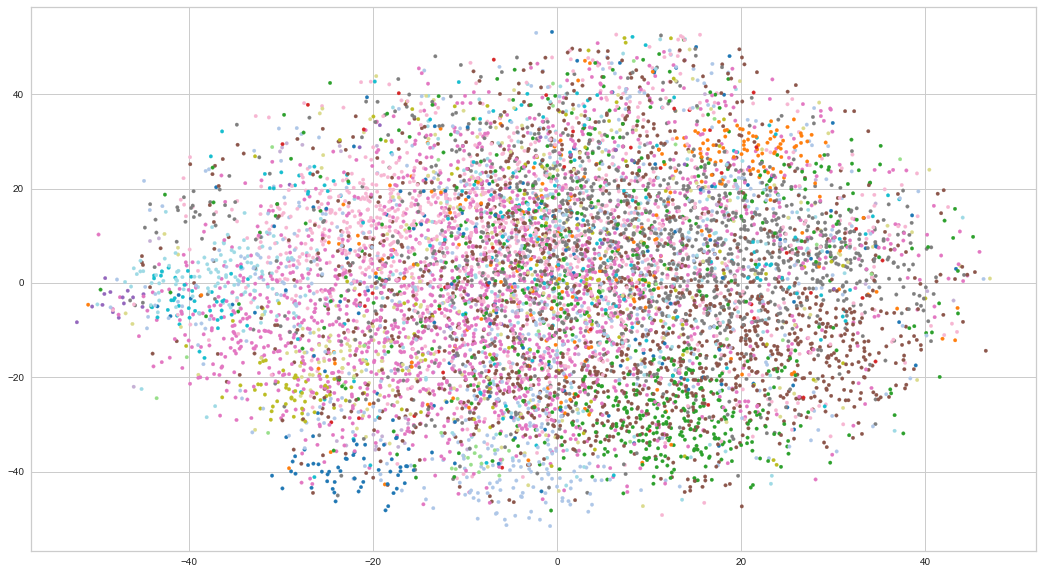

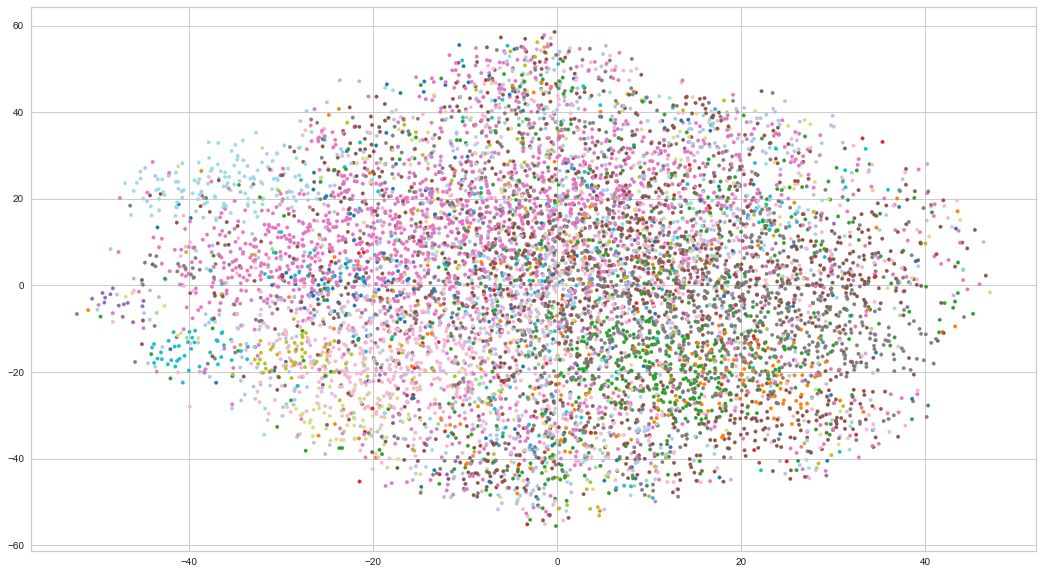

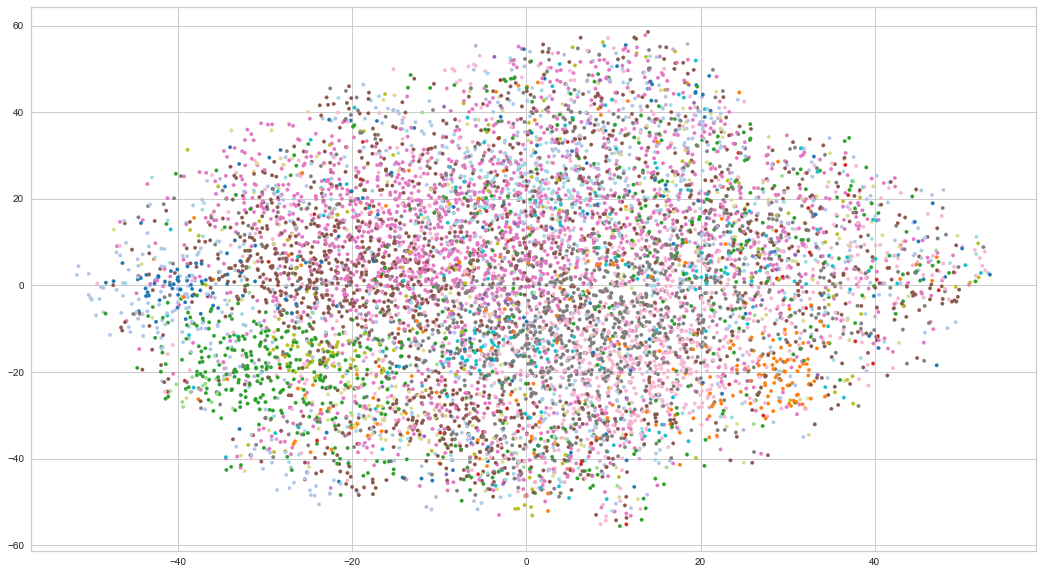

In [0]:
col = list_personality

plt.figure(0, figsize=(18,10))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.savefig("images/output_images/TSNE0.png")

plt.figure(1, figsize=(18,10))
plt.scatter(X_tsne[:,0], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.savefig("images/output_images/TSNE1.png")

plt.figure(2, figsize=(18,10))
plt.scatter(X_tsne[:,1], X_tsne[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.savefig("images/output_images/TSNE2.png")

sns.set_context("talk")
plt.show()

#### UMAP

In [0]:
embedding = umap.UMAP(metric='hellinger', random_state=42).fit_transform(tfidf)

In [0]:
np.amin(embedding)

-5.503086

In [0]:
embedding_positive = embedding-np.amin(embedding)

In [0]:
text_columns_umap = pd.DataFrame(embedding_positive)

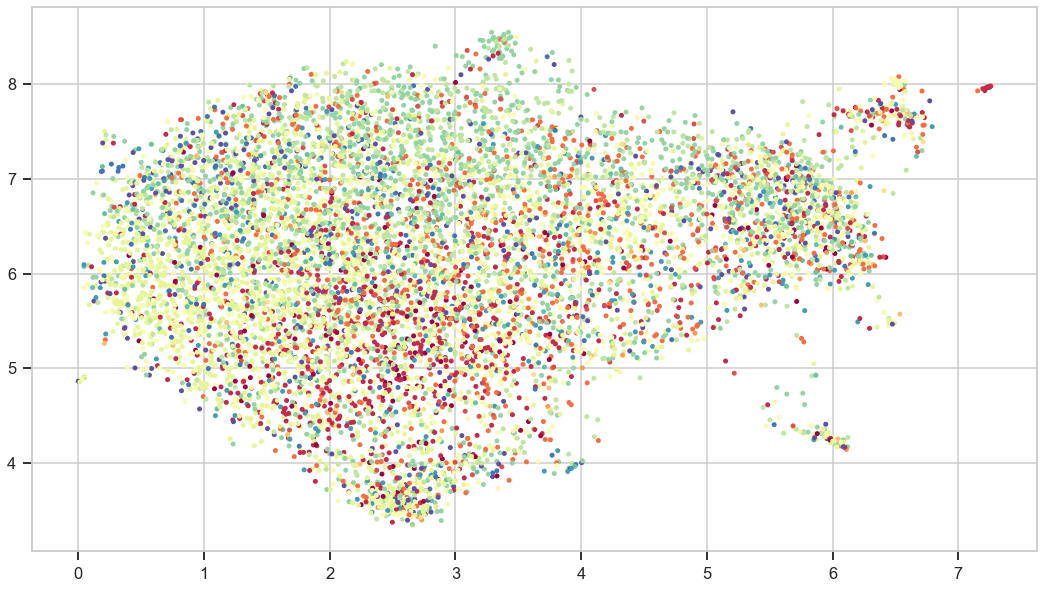

In [0]:
plt.figure(figsize=(18,10))
plt.scatter(embedding_positive[:, 0], embedding_positive[:, 1], c=col, cmap='Spectral', s=12)


sns.set_context("talk")
plt.savefig("images/output_images/UMAP_embedding_positive.png")
plt.show()

#### UMAP on TSVD

In [0]:
embedding_svd = umap.UMAP(metric='hellinger', random_state=42).fit_transform(svd_vec_positive)

In [0]:
np.amin(embedding_svd)

-1.8779627

In [0]:
embedding_svd_positive = embedding_svd-np.amin(embedding_svd)

In [0]:
text_columns_umap_svd = pd.DataFrame(embedding_svd_positive)

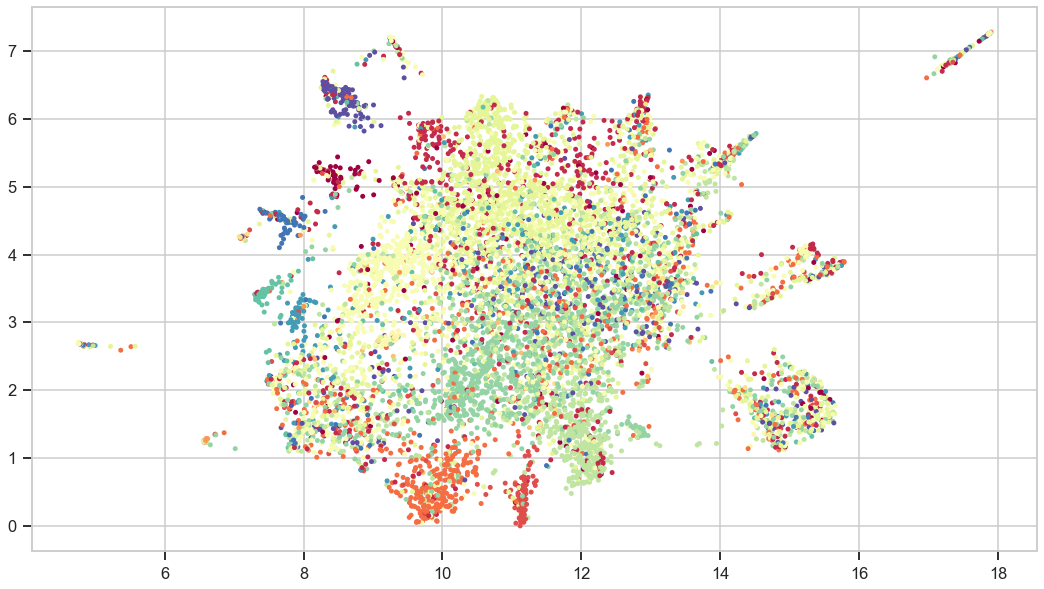

In [0]:
plt.figure(figsize=(18,10))
plt.scatter(embedding_svd_positive[:, 0], embedding_svd_positive[:, 1], c=col, cmap='Spectral', s=12)


sns.set_context("talk")
plt.savefig("images/output_images/UMAP_embedding_svd_positive.png")
plt.show()

### Get new numerical columns

I will get the original dataframe with its posts lengths and variances, dummies from every type and dummies on every type dimension axis.

In [0]:
def var_row(row):
    lst = []
    for word in row.split("|||"):
        lst.append(len(word.split()))
    return np.var(lst)

mbti_df["words_per_comment"] = mbti_df["posts"].apply(lambda x: len(x.split())/50)
mbti_df["variance_of_word_counts"] = mbti_df["posts"].apply(lambda x: var_row(x))

In [0]:
type_dummies = pd.get_dummies(text_columns["type"])
text_columns.drop(["text"], axis=1, inplace=True)
text_columns = pd.concat([text_columns, mbti_df["words_per_comment"], mbti_df["variance_of_word_counts"], 
                          type_dummies], axis=1,levels=None ,sort=False)

In [0]:
map1 = {"i": 0, "e": 1}
map2 = {"n": 0, "s": 1}
map3 = {"t": 0, "f": 1}
map4 = {"j": 0, "p": 1}
text_columns["i-e"] = text_columns["type"].astype(str).str[0]
text_columns["i-e"] = text_columns["i-e"].map(map1)
text_columns["n-s"] = text_columns["type"].astype(str).str[1]
text_columns["n-s"] = text_columns["n-s"].map(map2)
text_columns["t-f"] = text_columns["type"].astype(str).str[2]
text_columns["t-f"] = text_columns["t-f"].map(map3)
text_columns["j-p"] = text_columns["type"].astype(str).str[3]
text_columns["j-p"] = text_columns["j-p"].map(map4)

In [0]:
text_columns.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,i-e,n-s,t-f,j-p
0,infj,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,entp,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,intp,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,intj,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,entj,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Merge

I will merge the new numerical columns I created with the tfidf and different embedding results

#### Matrixes

##### Types

In [0]:
tfidf.shape

(8675, 88023)

In [0]:
tfidf_T = np.transpose(tfidf)

In [0]:
tfidf_T.shape

(88023, 8675)

In [0]:
list_personality.shape

(8675,)

In [0]:
train_array_T = sparse.vstack((list_personality, tfidf_T), format="csr")
train_array_types = np.transpose(train_array_T)

In [0]:
train_array_types.shape

(8675, 88024)

In [0]:
sparse.save_npz("data/output_sparse/train_array_types.npz", train_array_types)

##### Dimensions

In [0]:
dimensions_array = text_columns[["i-e", "n-s", "t-f", "j-p"]].to_numpy()

In [0]:
dimensions_array.shape

(8675, 4)

In [0]:
savetxt("data/output_csv/dimensions.csv", dimensions_array, delimiter=",")

In [0]:
train_array_dimensions = sparse.hstack((dimensions_array, tfidf), format="csr")

In [0]:
train_array_dimensions.shape

(8675, 88027)

In [0]:
sparse.save_npz("data/output_sparse/train_array_dimensions.npz", train_array_dimensions)

#### Truncated SVD

##### Dimensions

In [0]:
#text_columns.drop(["type"], axis=1, inplace=True)
result_svd_vec_dimensions = pd.concat([text_columns, text_columns_svd_vec], axis=1,levels=None ,sort=False)

In [0]:
result_svd_vec_dimensions.drop(["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj", 
                             "intp", "isfj", "isfp", "istj", "istp"], axis=1, inplace=True)

In [0]:
result_svd_vec_dimensions.to_csv("data/output_csv/result_svd_vec_dimensions.csv")

In [0]:
result_svd_vec_dimensions.head()

,type,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,infj,11.12,135.2900,0,0,1,0,0.575864,0.341900,0.330206,0.333370,0.426315,0.287361,0.403853,0.358249,0.370862,0.306908,0.333364,0.367469,0.387132,0.343488,0.328884,0.385098,0.347493,0.355731,0.353783,0.362082,0.366606,0.335523,0.328812,0.351158,0.356166,0.378324,0.371962,0.351721,0.346530,0.363045,0.320588,0.383153,0.347650,0.308086,0.353940,0.331389,0.336363,0.352080,0.396370,0.387154,0.351546,0.382030,0.399998,0.383447,0.396082,0.395256,0.414798,0.317389,0.422315,0.332296,0.384325,0.386854,0.394751,0.352069,0.306004,0.357322,0.366933,0.315608,0.331737,0.355515,0.407159,0.379756,0.374847,0.344814,0.338037,0.322427,0.359317,0.380492,0.359243,0.394337,0.400044,0.380884,0.352755,0.341547,0.342134,0.348767,0.334700,0.355056,0.351102,0.366654,0.347544,0.371199,0.380349,0.361264,0.369471,0.369211,0.382829,0.394170,0.394868,0.363783,0.343928,0.360159,0.358680,0.351273,0.402498,0.357498,0.376758,0.379303,0.367843,0.375516
1,entp,23.40,187.4756,1,0,0,1,0.668875,0.391520,0.354378,0.349749,0.380692,0.321320,0.321578,0.304752,0.315956,0.379222,0.296456,0.421608,0.339213,0.298426,0.309298,0.296538,0.325822,0.251998,0.360878,0.350645,0.333856,0.345074,0.373529,0.291949,0.358112,0.382980,0.318974,0.338868,0.384118,0.356325,0.380080,0.391521,0.364916,0.312428,0.324217,0.368759,0.346908,0.391851,0.363932,0.333563,0.368159,0.340700,0.353354,0.368683,0.381920,0.341228,0.396941,0.362724,0.408734,0.362691,0.369429,0.298516,0.357688,0.346923,0.358598,0.333420,0.338070,0.361879,0.328551,0.382577,0.371850,0.380673,0.376132,0.393135,0.378937,0.363274,0.387899,0.363812,0.377962,0.404112,0.332321,0.350342,0.385821,0.352933,0.387121,0.345692,0.349740,0.396510,0.397804,0.387546,0.392352,0.386317,0.401374,0.376990,0.367014,0.349624,0.355579,0.356306,0.352988,0.370427,0.351512,0.375683,0.352008,0.356475,0.332874,0.386907,0.356917,0.354533,0.377601,0.337164
2,intp,16.72,180.6900,0,0,0,1,0.632933,0.323963,0.318553,0.318146,0.374402,0.340386,0.400942,0.354021,0.343210,0.334880,0.346226,0.342561,0.364715,0.336149,0.380440,0.351843,0.337242,0.376145,0.397116,0.334761,0.381209,0.375485,0.339996,0.350440,0.344151,0.359108,0.369028,0.351500,0.403080,0.347802,0.378516,0.374077,0.371851,0.362913,0.385513,0.405862,0.365427,0.343661,0.383218,0.340804,0.383414,0.360855,0.363925,0.335875,0.345861,0.323027,0.338854,0.328991,0.345751,0.397529,0.358675,0.327893,0.387522,0.415017,0.331714,0.312209,0.352969,0.350624,0.402796,0.308455,0.380013,0.361225,0.368925,0.400451,0.375924,0.393967,0.352957,0.335162,0.410373,0.381009,0.412820,0.374646,0.358162,0.371717,0.378905,0.367749,0.365633,0.323646,0.318996,0.348761,0.355495,0.338043,0.393994,0.388034,0.341480,0.355253,0.367895,0.354701,0.375618,0.375970,0.332374,0.354798,0.362468,0.352909,0.367732,0.342600,0.336408,0.357758,0.344202,0.391195
3,intj,21.28,181.8324,0,0,0,0,0.678780,0.478042,0.341578,0.293118,0.348845,0.374590,0.378487,0.369826,0.443440,0.393531,0.376966,0.359269,0.358724,0.353550,0.388555,0.398187,0.380191,0.371280,0.336121,0.355353,0.365410,0.351251,0.368783,0.332270,0.343582,0.338042,0.369817,0.369299,0.317864,0.385894,0.330617,0.390356,0.300601,0.361044,0.333315,0.356473,0.357851,0.330093,0.356521,0.399194,0.414679,0.464246,0.335476,0.426460,0.343481,0.381157,0.363174,0.376184,0.366911,0.323196,0.373276,0.384618,0.322663,0.327092,0.389015,0.379307,0.378733,0.326742,0.348621,0.338290,0.332756,0.326554,0.380733,0.365949,0.310257,0.373764,0.369169,0.327124,0.336105,0.360106,0.363751,0.391533,0.364982,0.336144,0.332701,0.346393,0.352721,0.339206,0.348628,0.332218,0.407927,0.372839,0.350671,0.320352,0.349784,0.369004,0.387349,0.348680,0.330608,0.370895,0.370720,0.33569

##### Types

In [0]:
result_svd_vec_types = pd.concat([text_columns, text_columns_svd_vec], axis=1,levels=None ,sort=False)

In [0]:
result_svd_vec_types.drop(["i-e", "n-s", "t-f", "j-p"], axis=1, inplace=True)

In [0]:
result_svd_vec_types.to_csv("data/output_csv/result_svd_vec_types.csv")

In [0]:
result_svd_vec_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,infj,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.575864,0.341900,0.330206,0.333370,0.426315,0.287361,0.403853,0.358249,0.370862,0.306908,0.333364,0.367469,0.387132,0.343488,0.328884,0.385098,0.347493,0.355731,0.353783,0.362082,0.366606,0.335523,0.328812,0.351158,0.356166,0.378324,0.371962,0.351721,0.346530,0.363045,0.320588,0.383153,0.347650,0.308086,0.353940,0.331389,0.336363,0.352080,0.396370,0.387154,0.351546,0.382030,0.399998,0.383447,0.396082,0.395256,0.414798,0.317389,0.422315,0.332296,0.384325,0.386854,0.394751,0.352069,0.306004,0.357322,0.366933,0.315608,0.331737,0.355515,0.407159,0.379756,0.374847,0.344814,0.338037,0.322427,0.359317,0.380492,0.359243,0.394337,0.400044,0.380884,0.352755,0.341547,0.342134,0.348767,0.334700,0.355056,0.351102,0.366654,0.347544,0.371199,0.380349,0.361264,0.369471,0.369211,0.382829,0.394170,0.394868,0.363783,0.343928,0.360159,0.358680,0.351273,0.402498,0.357498,0.376758,0.379303,0.367843,0.375516
1,entp,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.668875,0.391520,0.354378,0.349749,0.380692,0.321320,0.321578,0.304752,0.315956,0.379222,0.296456,0.421608,0.339213,0.298426,0.309298,0.296538,0.325822,0.251998,0.360878,0.350645,0.333856,0.345074,0.373529,0.291949,0.358112,0.382980,0.318974,0.338868,0.384118,0.356325,0.380080,0.391521,0.364916,0.312428,0.324217,0.368759,0.346908,0.391851,0.363932,0.333563,0.368159,0.340700,0.353354,0.368683,0.381920,0.341228,0.396941,0.362724,0.408734,0.362691,0.369429,0.298516,0.357688,0.346923,0.358598,0.333420,0.338070,0.361879,0.328551,0.382577,0.371850,0.380673,0.376132,0.393135,0.378937,0.363274,0.387899,0.363812,0.377962,0.404112,0.332321,0.350342,0.385821,0.352933,0.387121,0.345692,0.349740,0.396510,0.397804,0.387546,0.392352,0.386317,0.401374,0.376990,0.367014,0.349624,0.355579,0.356306,0.352988,0.370427,0.351512,0.375683,0.352008,0.356475,0.332874,0.386907,0.356917,0.354533,0.377601,0.337164
2,intp,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.632933,0.323963,0.318553,0.318146,0.374402,0.340386,0.400942,0.354021,0.343210,0.334880,0.346226,0.342561,0.364715,0.336149,0.380440,0.351843,0.337242,0.376145,0.397116,0.334761,0.381209,0.375485,0.339996,0.350440,0.344151,0.359108,0.369028,0.351500,0.403080,0.347802,0.378516,0.374077,0.371851,0.362913,0.385513,0.405862,0.365427,0.343661,0.383218,0.340804,0.383414,0.360855,0.363925,0.335875,0.345861,0.323027,0.338854,0.328991,0.345751,0.397529,0.358675,0.327893,0.387522,0.415017,0.331714,0.312209,0.352969,0.350624,0.402796,0.308455,0.380013,0.361225,0.368925,0.400451,0.375924,0.393967,0.352957,0.335162,0.410373,0.381009,0.412820,0.374646,0.358162,0.371717,0.378905,0.367749,0.365633,0.323646,0.318996,0.348761,0.355495,0.338043,0.393994,0.388034,0.341480,0.355253,0.367895,0.354701,0.375618,0.375970,0.332374,0.354798,0.362468,0.352909,0.367732,0.342600,0.336408,0.357758,0.344202,0.391195
3,intj,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.678780,0.478042,0.341578,0.293118,0.348845,0.374590,0.378487,0.369826,0.443440,0.393531,0.376966,0.359269,0.358724,0.353550,0.388555,0.398187,0.380191,0.371280,0.336121,0.355353,0.365410,0.351251,0.368783,0.332270,0.343582,0.338042,0.369817,0.369299,0.317864,0.385894,0.330617,0.390356,0.300601,0.361044,0.333315,0.356473,0.357851,0.330093,0.356521,0.399194,0.414679,0.464246,0.335476,0.426460,0.343481,0.381157,0.363174,0.376184,0.366911,0.323196,0.373276,0.384618,0.322663,0.327092,0.389015,0.379307,0.378733,0.326742,0.348621,0.338290,0.332756,0.326554,0.380733,0.365949,0.310257,0.373764,0.369169,0.327124,0.336105,0.360106,0.363751,0.391533,0.364982,0.336144,

#### UMAP

##### Dimensions

In [0]:
result_umap_dimensions = pd.concat([text_columns, text_columns_umap], axis=1,levels=None ,sort=False)

In [0]:
result_umap_dimensions.drop(["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj", 
                             "intp", "isfj", "isfp", "istj", "istp"], axis=1, inplace=True)

In [0]:
result_umap_dimensions.to_csv("data/output_csv/result_umap_dimensions.csv")

In [0]:
result_umap_dimensions.head()

,type,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1
0,infj,11.12,135.2900,0,0,1,0,3.910143,7.477874
1,entp,23.40,187.4756,1,0,0,1,3.938040,5.939636
2,intp,16.72,180.6900,0,0,0,1,3.740153,5.486389
3,intj,21.28,181.8324,0,0,0,0,5.415134,7.452929
4,entj,19.34,196.4576,1,0,0,0,2.083198,7.512875


##### Types

In [0]:
result_umap_types = pd.concat([text_columns, text_columns_umap], axis=1,levels=None ,sort=False)

In [0]:
result_umap_types.drop(["i-e", "n-s", "t-f", "j-p"], axis=1, inplace=True)

In [0]:
result_umap_types.to_csv("data/output_csv/result_umap_types.csv")

In [0]:
result_umap_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,infj,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.910143,7.477874
1,entp,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.938040,5.939636
2,intp,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.740153,5.486389
3,intj,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.415134,7.452929
4,entj,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.083198,7.512875


#### UMAP

##### Dimensions

In [0]:
result_umap_dimensions = pd.concat([text_columns, text_columns_umap], axis=1,levels=None ,sort=False)

In [0]:
result_umap_dimensions.drop(["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj", 
                             "intp", "isfj", "isfp", "istj", "istp"], axis=1, inplace=True)

In [0]:
result_umap_dimensions.to_csv("data/output_csv/result_umap_dimensions.csv")

In [0]:
result_umap_dimensions.head()

,type,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1
0,infj,11.12,135.2900,0,0,1,0,12.761392,3.539108
1,entp,23.40,187.4756,1,0,0,1,9.733282,0.578183
2,intp,16.72,180.6900,0,0,0,1,12.002575,4.193234
3,intj,21.28,181.8324,0,0,0,0,9.521256,1.823716
4,entj,19.34,196.4576,1,0,0,0,11.170195,0.726455


##### Types

In [0]:
result_umap_types = pd.concat([text_columns, text_columns_umap], axis=1,levels=None ,sort=False)

In [0]:
result_umap_types.drop(["i-e", "n-s", "t-f", "j-p"], axis=1, inplace=True)

In [0]:
result_umap_types.to_csv("data/output_csv/result_umap_types.csv")

In [0]:
result_umap_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,infj,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,12.761392,3.539108
1,entp,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,9.733282,0.578183
2,intp,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12.002575,4.193234
3,intj,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9.521256,1.823716
4,entj,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11.170195,0.726455


#### UMAP on TSVD

##### Dimensions

In [0]:
result_umap_svd_dimensions = pd.concat([text_columns, text_columns_umap_svd], axis=1,levels=None ,sort=False)

In [0]:
result_umap_svd_dimensions.drop(["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj", 
                             "intp", "isfj", "isfp", "istj", "istp"], axis=1, inplace=True)

In [0]:
result_umap_svd_dimensions.to_csv("data/output_csv/result_umap_svd_dimensions.csv")

In [0]:
result_umap_svd_dimensions.head()

,type,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1
0,infj,11.12,135.2900,0,0,1,0,12.761392,3.539108
1,entp,23.40,187.4756,1,0,0,1,9.733282,0.578183
2,intp,16.72,180.6900,0,0,0,1,12.002575,4.193234
3,intj,21.28,181.8324,0,0,0,0,9.521256,1.823716
4,entj,19.34,196.4576,1,0,0,0,11.170195,0.726455


##### Types

In [0]:
result_umap_svd_types = pd.concat([text_columns, text_columns_umap_svd], axis=1,levels=None ,sort=False)

In [0]:
result_umap_svd_types.drop(["i-e", "n-s", "t-f", "j-p"], axis=1, inplace=True)

In [0]:
result_umap_svd_types.to_csv("data/output_csv/result_umap_svd_types.csv")

In [0]:
result_umap_svd_types.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,infj,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,12.761392,3.539108
1,entp,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,9.733282,0.578183
2,intp,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12.002575,4.193234
3,intj,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9.521256,1.823716
4,entj,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11.170195,0.726455
